In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)
tf.config.set_visible_devices(gpus[0], 'GPU')
    

from src.learners.learner_base import LearnerBase
from src.models.nn_model import NNAUVModel

from src.model import get_model
from src.learner import get_learner

import pandas as pd
import numpy as np
import bagpy
from bagpy import bagreader

import os
from tqdm import tqdm


import matplotlib.pyplot as plt
%matplotlib inline


InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: all CUDA-capable devices are busy or unavailable

# Create Model and Learner.


In [3]:
model = get_model({"type": "auv_nn"}, tf.Variable(1), 0.1, 13, 6, "learn_test")
learner = get_learner(model, bufferSize=250*500, log=True, logPath="./learnerTests/")
dataDir = '../../../log/data/'
valDir = '../../../log/data_val/'

# Load data

- load data from file.
- Create a learning set and validat

In [4]:
data = os.path.join(dataDir, 'run{}.bag')
val = os.path.join(valDir, 'run{}.bag')

# Compute required step size and compare it to the rosbag

    dt = 0.1
need to interpolate the data such that we have samples at ~10hz.


# Feed the data to the learner.
 - Need to resample the data such that the data frequency is ~10Hz.
 - Feed the transition to the learner.


In [5]:
def get_state(stateDf):
    state = np.zeros(13)
    
    # Position
    state[0] = stateDf['pose.pose.position.x']
    state[1] = stateDf['pose.pose.position.y']
    state[2] = stateDf['pose.pose.position.z']
    # Quaternion
    state[3] = stateDf['pose.pose.orientation.x']
    state[4] = stateDf['pose.pose.orientation.y']
    state[5] = stateDf['pose.pose.orientation.z']
    state[6] = stateDf['pose.pose.orientation.w']
    # Linear Velocity
    state[7] = stateDf['twist.twist.linear.x']
    state[8] = stateDf['twist.twist.linear.y']
    state[9] = stateDf['twist.twist.linear.z']
    # Angular Velocity
    state[10] = stateDf['twist.twist.angular.x']
    state[11] = stateDf['twist.twist.angular.y']
    state[12] = stateDf['twist.twist.angular.z']
    
    return state

def get_action(actionDf):
    action = np.zeros(6)
    # Linear force
    action[0] = actionDf['wrench.force.x']
    action[1] = actionDf['wrench.force.y']
    action[2] = actionDf['wrench.force.z']
    # Torque
    action[3] = actionDf['wrench.torque.x']
    action[4] = actionDf['wrench.torque.y']
    action[5] = actionDf['wrench.torque.z']
    return action

def feed_learner(learner, directory):
    trajs = 500
    #trajs = 5
    for i in tqdm(range(trajs)):
        # Read the bag.
        data = os.path.join(dataDir, 'run{}.bag'.format(i))
        bag = bagreader(data, verbose=False)
        pose = pd.read_csv(bag.message_by_topic('/rexrov2/pose_gt'))
        action = pd.read_csv(bag.message_by_topic('/thruster_input'))
        
        # Resample the datapoints to have a 10Hz frequency
        intPose = pose.copy()

        intPose['time'] = pd.to_datetime(pose['Time'], unit='s').round('ms')

        intPoseUp = intPose.set_index('time').resample('ms').interpolate('linear').resample('0.1S').agg('first')
        intPoseUp.drop(intPoseUp.index[0], inplace=True)

        intAction = action.copy()
        intAction = intAction.drop(action.index[-1])
        intAction['Time'] = pd.to_datetime(intAction["Time"], unit='s').round('ms')

        # For some black magic reason the resamples doesn't seem to work with the aciton frame.
        intActionUp = intAction.set_index('Time').resample('ms').interpolate('linear').resample('0.1S').agg('first').reset_index()
        
        #if intActionUp['Time'].shape != intPoseUp['Time'].shape:
            #print("Error do not have the same number of samples for the pose and the action")

        for j in range(intPoseUp['Time'].shape[0]-1):
            state = get_state(intPoseUp.iloc[j])
            next_state = get_state(intPoseUp.iloc[j+1])
            act = get_action(intActionUp.iloc[j])
            learner.add_rb(state, act, next_state)

In [6]:
feed_learner(learner, dataDir)

100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


In [6]:
def validation(valDir, nbRuns):
    data = os.path.join(valDir, 'run{}.bag')
    trajs = [] 
    actionSeqs = [] 
    for i in range(nbRuns):
        file = data.format(i)
        bag = bagreader(file, verbose=False)
        pose = pd.read_csv(bag.message_by_topic('/rexrov2/pose_gt'))
        action = pd.read_csv(bag.message_by_topic('/thruster_input'))

        # Resample the datapoints to have a 10Hz frequency
        intPose = pose.copy()
        
        intPose['time'] = pd.to_datetime(pose['Time'], unit='s').round('ms')

        intPoseUp = intPose.set_index('time').resample('ms').interpolate('linear').resample('0.1S').agg('first')
        intPoseUp.drop(intPoseUp.index[0], inplace=True)

        intAction = action.copy()
        intAction = intAction.drop(action.index[-1])
        intAction['Time'] = pd.to_datetime(intAction["Time"], unit='s').round('ms')

        # For some black magic reason the resamples doesn't seem to work with the aciton frame.
        intActionUp = intAction.set_index('Time').resample('ms').interpolate('linear').resample('0.1S').agg('first').reset_index()

        traj = np.zeros(shape=(intPoseUp['Time'].shape[0], 13))
        actionSeq = np.zeros(shape=(intActionUp['Time'].shape[0], 6))

        traj[:, 0] = intPoseUp['pose.pose.position.x']
        traj[:, 1] = intPoseUp['pose.pose.position.y']
        traj[:, 2] = intPoseUp['pose.pose.position.z']
    
        traj[:, 3] = intPoseUp['pose.pose.orientation.x']
        traj[:, 4] = intPoseUp['pose.pose.orientation.x']
        traj[:, 5] = intPoseUp['pose.pose.orientation.x']
        traj[:, 6] = intPoseUp['pose.pose.orientation.x']

        traj[:, 7] = intPoseUp['twist.twist.linear.x']
        traj[:, 8] = intPoseUp['twist.twist.linear.y']
        traj[:, 9] = intPoseUp['twist.twist.linear.z']

        traj[:, 10] = intPoseUp['twist.twist.angular.x']
        traj[:, 11] = intPoseUp['twist.twist.angular.y']
        traj[:, 12] = intPoseUp['twist.twist.angular.z']

        actionSeq[:, 0] = intActionUp['wrench.force.x']    
        actionSeq[:, 1] = intActionUp['wrench.force.y']
        actionSeq[:, 2] = intActionUp['wrench.force.z']

        actionSeq[:, 3] = intActionUp['wrench.torque.x']
        actionSeq[:, 4] = intActionUp['wrench.torque.y']
        actionSeq[:, 5] = intActionUp['wrench.torque.z']

        trajs.append(np.expand_dims(traj, axis=0))
        actionSeqs.append(np.expand_dims(actionSeq, axis=0))
    trajs = np.concatenate(trajs, axis=0)
    actionSeqs = np.concatenate(actionSeqs, axis=0)
    return trajs, actionSeqs


In [7]:
trajs, actionSeqs = validation(valDir, 19)

*****  Grid  *****
lr:  0.0001
bs:  -1
e:  100
fold:  [32082.113296906668, 31802.590077996458, 32314.343536260887, 31948.96673696726, 31426.104130285148, 31135.84400385089, 32399.488536395995, 32001.758603168662, 32255.153027014778, 31491.67198753338]
mean:  31885.803393638012


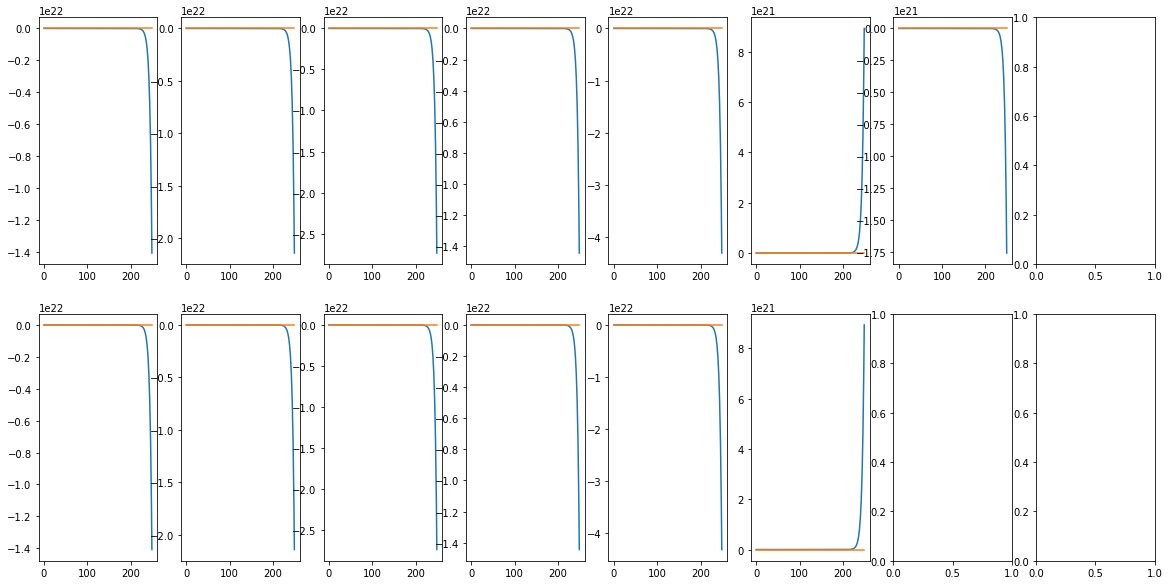

validation error:  9.355209157973307e+25
*****  Grid  *****
lr:  0.0001
bs:  -1
e:  500
fold:  [31994.11441479687, 31504.691912051552, 31651.338895919904, 32120.826360423103, 31402.075335980084, 31790.228899015372, 31411.3718839412, 32704.315476753025, 31811.58646915133, 32467.556559029348]
mean:  31885.810620706172


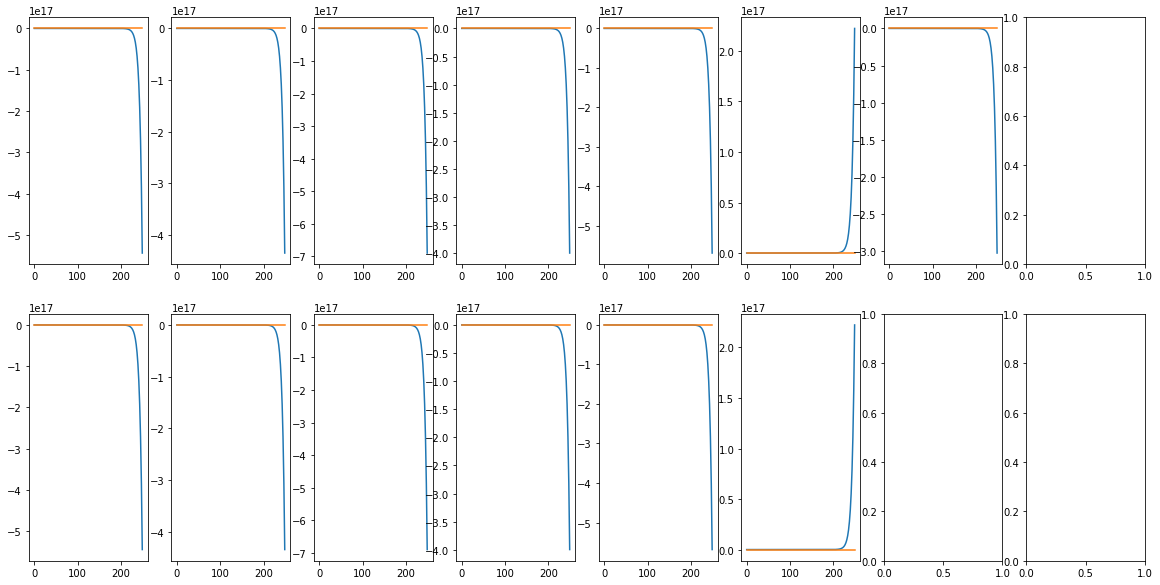

validation error:  3.4321361979746936e+20
*****  Grid  *****
lr:  0.0001
bs:  -1
e:  1000
fold:  [31838.160278529944, 31682.724446503675, 32489.6497032274, 31606.174727767764, 31971.99996340348, 31937.25312960356, 32205.661039581497, 31638.865355866095, 31791.607405616447, 31695.93671597698]
mean:  31885.803276607687


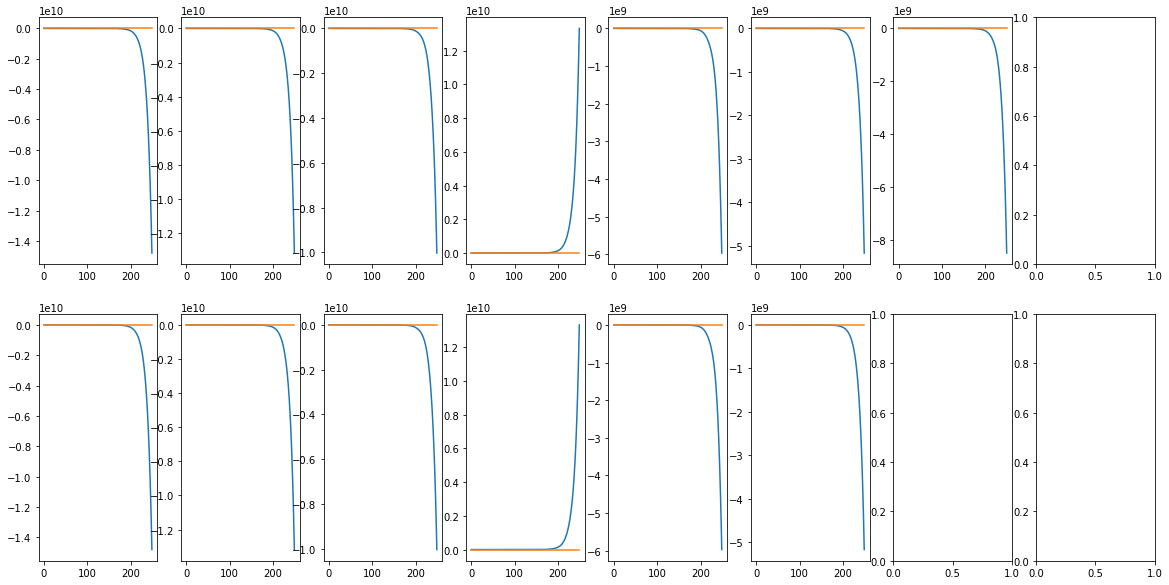

validation error:  16712600633909.0
*****  Grid  *****
lr:  0.0112
bs:  -1
e:  100
fold:  [31215.516131155026, 31167.79714597715, 31669.64770371255, 32836.05018582096, 32764.745315859356, 32149.88452209049, 31689.564441336574, 31386.331525141595, 32218.838536028536, 31759.652041809684]
mean:  31885.802754893193


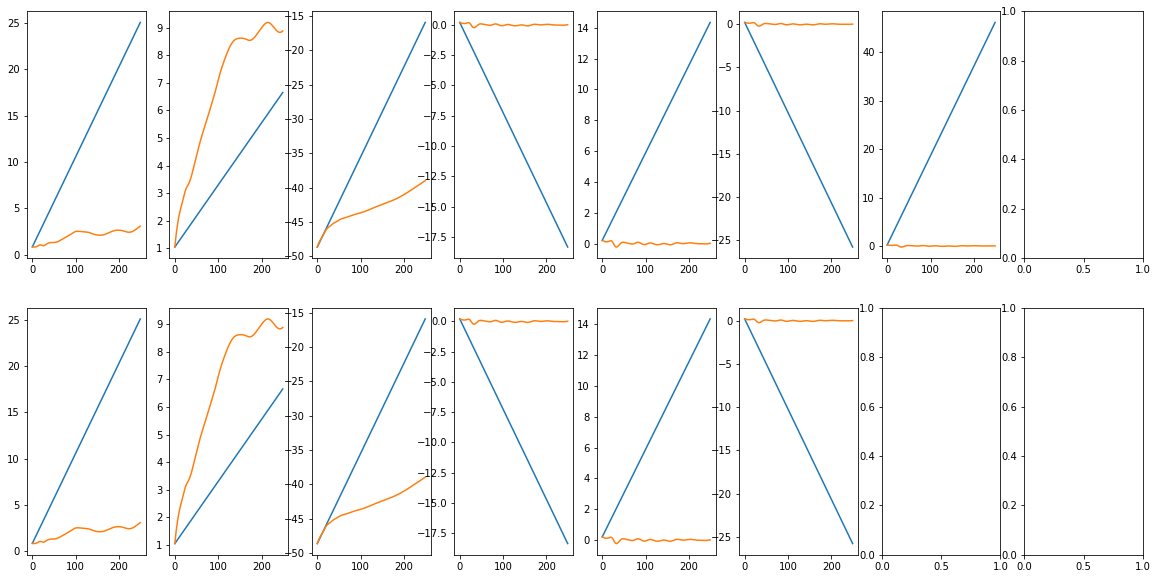

validation error:  569.6209517611089


In [ ]:
learner.grid_search(trajs, actionSeqs)